## <a name="C4">0. Importation et fonctions</a>

### 0.1 Importation des librairies

In [726]:
import warnings
warnings.filterwarnings('ignore')

import sqlite3
import pandas as pd
import numpy as np
from pandasql import sqldf

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio

# Feature Engineering
from sklearn import model_selection, preprocessing
from feature_engine import selection, imputation, encoding, discretisation, transformation, outliers, pipeline

# Clustering
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
import matplotlib.pyplot as plt


### 0.2 Définition des fonctions

In [697]:
def plot_histograms(data, vars, categorical=False, h=False, top=None):
    num_vars = len(vars)
    num_cols = min(3, num_vars)
    num_rows = (num_vars + num_cols - 1) // num_cols
    
    fig = make_subplots(rows=num_rows, cols=num_cols)
    
    for i, var in enumerate(vars):
        row = (i // num_cols) + 1
        col = (i % num_cols) + 1

        if categorical:
            hist_data = data[var].value_counts().reset_index()
            if top:
                hist_data = hist_data[0:top]
                
            if h:
                trace = go.Bar(x=hist_data['count'], y=hist_data[var], orientation='h')
            else:
                trace = go.Bar(x=hist_data[var], y=hist_data['count'], name=var)
                
            fig.add_trace(trace, row=row, col=col)
                
        else:
            fig.add_trace(go.Histogram(x=data[var], nbinsx=50, name=var), row=row, col=col)
            
        fig.update_xaxes(title_text=var, row=row, col=col)
        fig.update_layout(height=len(vars)*150)
    
    fig.show()

In [698]:
def inspect_null_values(data):
    n_rows = data.shape[0]

    for var in data.columns:
        null_values = data[var].isnull().sum()
        null_values_share = round(null_values / n_rows * 100)
        print(f"{var} null values: {null_values}, share: {null_values_share}%")

In [699]:
def get_df_from_array(pipe, X_train, X_test=None):
    cols = pipe.get_feature_names_out()
    X_train = pd.DataFrame(X_train, columns=cols)
    if X_test:
        X_test = pd.DataFrame(X_test, columns=cols)
        return X_train, X_test
    else:
        return X_train

### 0.3 Importation des données

In [700]:
df = pd.read_csv('data/customer_dataset.csv').set_index('customer_unique_id')

## 1. Feature Engineering

### 2.1 Valeurs manquantes

In [701]:
# Missing values
df.isnull().sum()

zip_code                               0
city                                   0
state                                  0
nb_orders                              0
average_payment_value                  1
average_payment_installments           1
average_review_score                 716
average_delay                      93099
last_order_recency                     0
average_quantity_per_order           676
average_product_price_per_order      676
favorite_product_category           2091
dtype: int64

Pour certaines features, on pourra réaliser une imputation, au vu du peu de valeurs manquantes.  
Pour le délai, il manque une grande majorité des valeurs, ce qui est logique puisque le jeu de données ne contient quasi que des clients uniques. 

### 2.2 Distribution & outliers

L'analyse exploratoire a révelé la présence d'outliers, et des distributions asymétriques sur plusieurs features, ce qui pourra nécessiter des transformations sur certains modèles.

### 2.3 Cardinalité & labels rares

Certaines features catégorielles possèdent une haute cardinalité et de nombreuses modalités peu fréquentes.  
Je vais donc appliquer un regroupement de ces modalités rares, avant de réaliser l'encodage de toutes les features catégorielles.

### 2.4 Transformations

Certaines étapes du Feature engineering sont particuliérement utilisées et performantes sur certains types de modèle.  
Ici, j'applique dans un premier temps les transformations agnostiques du modèle, qui bénéficient à l'ensemble/la majorité des modèles de Machine Learning.

In [702]:
pipe = pipeline.Pipeline(
    [
        ('numerical_imputation', imputation.MeanMedianImputer(imputation_method='median')),
        ('categorical_imputation', imputation.CategoricalImputer(imputation_method='frequent')),
        ('rare_label_encoding', encoding.RareLabelEncoder()),
        ('categorical_encoding', encoding.OneHotEncoder())

    ]
)

In [703]:
pipe.fit(df)

Pipeline(steps=[('numerical_imputation', MeanMedianImputer()),
                ('categorical_imputation',
                 CategoricalImputer(imputation_method='frequent')),
                ('rare_label_encoding', RareLabelEncoder()),
                ('categorical_encoding', OneHotEncoder())])

In [704]:
X = pipe.transform(df)

In [705]:
# Transform X_train array back to a DataFrame
X = get_df_from_array(pipe, X)

In [706]:
pipe2 = pipeline.Pipeline(
    [
        ('distribution', transformation.YeoJohnsonTransformer()),
        ('scaler', preprocessing.StandardScaler())
    ]
)


pipe2.fit(X)
X = pipe2.transform(X)
X = get_df_from_array(pipe2, X)

In [707]:
X.isnull().sum()

zip_code                                            0
nb_orders                                           0
average_payment_value                               0
average_payment_installments                        0
average_review_score                                0
average_delay                                       0
last_order_recency                                  0
average_quantity_per_order                          0
average_product_price_per_order                     0
city_Rare                                           0
city_sao paulo                                      0
city_rio de janeiro                                 0
state_SP                                            0
state_Rare                                          0
state_MG                                            0
state_PR                                            0
state_RJ                                            0
state_RS                                            0
favorite_product_category_Ra

## 2. Clustering

### 2.1 K-Means

#### 2.1.1 Choix des features

Suite à quelques tests empiriques, il apparaît que l'utilisation d'un trop grand nombre de features ne donne pas de bonne segmentation.  
De plus, utiliser trop de variables en entrée risquerait de brouiller le potentiel d'utilisation des résultats par les équipes métier.  
Je décide donc de réduire la dimensionalité, en gardant les éléments de la segmentation RFM, ainsi que la satisfaction client.

In [708]:
X.head()

,zip_code,nb_orders,average_payment_value,average_payment_installments,average_review_score,average_delay,last_order_recency,average_quantity_per_order,average_product_price_per_order,city_Rare,...,state_RJ,state_RS,favorite_product_category_Rare,favorite_product_category_utilidades_domesticas,favorite_product_category_esporte_lazer,favorite_product_category_informatica_acessorios,favorite_product_category_cama_mesa_banho,favorite_product_category_moveis_decoracao,favorite_product_category_beleza_saude,favorite_product_category_relogios_presentes
0,-0.511276,0.0,0.437209,0.139356,-0.468425,-0.002684,1.371146,-0.334089,0.540602,0.538179,...,-0.384499,-0.241049,1.050254,-0.246938,-0.288146,-0.267878,-0.361176,-0.25751,-0.313913,-0.24384
1,-0.832657,0.0,1.343704,1.528848,0.789114,-0.002684,0.086314,-0.334089,1.389897,0.538179,...,-0.384499,-0.241049,-0.952151,4.049597,-0.288146,-0.267878,-0.361176,-0.25751,-0.313913,-0.24384
2,-2.182361,0.0,0.521776,1.445459,0.789114,-0.002684,-0.853607,-0.334089,0.659380,-1.858117,...,-0.384499,-0.241049,1.050254,-0.246938,-0.288146,-0.267878,-0.361176,-0.25751,-0.313913,-0.24384
3,-0.918678,0.0,0.631487,-0.951400,0.789114,-0.002684,-0.315724,-0.334089,0.731278,0.538179,...,-0.384499,-0.241049,1.050254,-0.246938,-0.288146,-0.267878,-0.361176,-0.25751,-0.313913,-0.24384
4,-0.595961,0.0,1.048269,1.528848,0.789114,-0.002684,-1.596975,-0.334089,1.165782,0.538179,...,-0.384499,-0.241049,1.050254,-0.246938,-0.288146,-0.267878,-0.361176,-0.25751,-0.313913,-0.24384


In [709]:
features_list = [
    'average_payment_value', 
    # 'nb_orders', 
    'average_review_score', 
    'last_order_recency'
    ]

X_reduced = X[features_list]
X_sample_reduced = pd.DataFrame(X_reduced).sample(20000)


#### 2.1.2 Recherche du nombre optimal de clusters

Je vais chercher le nombre de clusters idéal pour K-Means.  
Pour cela, je vais d'abord me baser sur deux métriques "objectives": 
- La méthode Elbow, qui évalue la compacité et donc la cohérence des points au sein des clusters
- Le score de silhouette, qui relativise cette compacité avec la séparation entre les différents clusters

In [710]:
n_clusters = range(3,10)
silhouette_scores = []
wcss = []

# Test du clustering K-Means sur plusieurs N clusters (3-9)
for i in n_clusters:
    cls = KMeans(
    n_clusters=i,
    init='k-means++',
    n_init='auto',
    algorithm='lloyd',
    max_iter=300,
    tol=1e-4,
    random_state=42
)
    
    cls.fit(X_sample_reduced)
    labels = cls.labels_
    score = metrics.silhouette_score(X_sample_reduced, labels)
    inertia = cls.inertia_
    silhouette_scores.append(score)
    wcss.append(inertia)

In [711]:
# Evaluation de la compacité et de la séparation des clusters
fig = make_subplots(rows=1, cols=2, subplot_titles=("Silhouette Score", "Elbow Method"))

fig.add_trace(go.Scatter(
    x=list(n_clusters),
    y=silhouette_scores,
    mode='lines+markers',
    name='Silhouette Score'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=list(n_clusters),
    y=wcss,
    mode='lines+markers',
    name='WCSS'
), row=1, col=2)

fig.update_layout(
    title='Cluster Analysis',
    xaxis_title='Number of clusters',
    template='plotly_white'
)

fig.show()

Le nombre optimal de clusters semble être: **7** clusters.

#### 2.1.3 Analyse de la segmentation à 7 clusters

In [720]:
kmeans_clusters_nb = 7

In [721]:
# Initialisation du KMeans à 7 clusters

cls = KMeans(
    n_clusters=kmeans_clusters_nb,
    init='k-means++',
    n_init='auto',
    algorithm='lloyd',
    max_iter=300,
    tol=1e-4,
    random_state=42
)

# Entraînement du KMeans
cls.fit(X_reduced)
labels = cls.labels_
X_reduced['cluster'] = labels
X_reduced['cluster'] = X_reduced['cluster'].astype(str)
X_reduced = X_reduced.sort_values(by='cluster', key=lambda x: x.astype(int))


J'évalue la forme des clusters avec les pairplots de Seaborn:

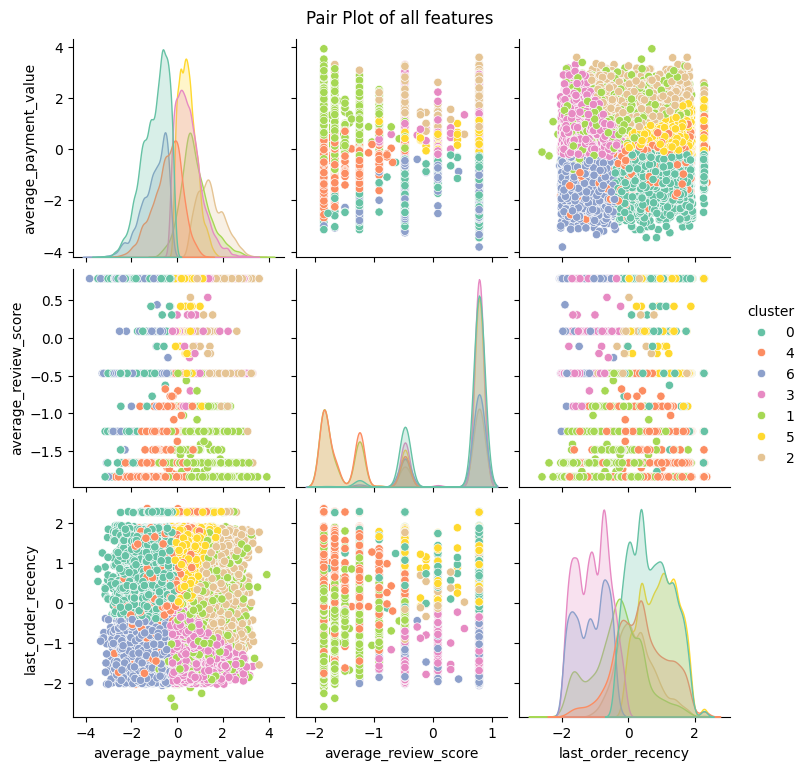

In [722]:
# Création des pairplots
sns.pairplot(X_reduced.sample(50000)[features_list + ['cluster']], hue='cluster', palette='Set2')
plt.suptitle("Pair Plot of all features", y=1.02)
plt.show()


J'évalue la répartition au sein des différents clusters:

In [723]:
cluster_sizes = X_reduced['cluster'].value_counts().sort_index()

fig = make_subplots(
    rows=1, cols=2, 
    specs=[[{'type': 'pie'}, {'type': 'bar'}]], 
    subplot_titles=("Cluster Size Distribution (Pie Chart)", "Cluster Size Distribution (Bar Chart)")
)

fig.add_trace(
    go.Pie(
        labels=cluster_sizes.index,
        values=cluster_sizes.values,
        hole=.3,  
        textinfo='label+percent',
    ),
    row=1, col=1
)

fig.add_trace(
    go.Bar(
        x=cluster_sizes.index,
        y=cluster_sizes.values,
        marker_color=px.colors.qualitative.G10,
    ),
    row=1, col=2
)

fig.update_layout(
    title_text="Cluster Size Representation",
    height=600,
    width=1000,
    showlegend=False 
)

fig.show()

Enfin, j'évalue leur interprétabilité avec une heatmap.

In [724]:
# Visualisation des caractéristiques de chaque cluster
px.imshow(X_reduced.groupby('cluster').mean())

On peut tirer quelques conclusions de cette segmentation RFM améliorée à 7 groupes:
1. *average_review_score*, *average_payment_value* et *last_order_recency* semblent être de forts critères distinctifs pour segmenter la clientèle
2. *average_review_score* semble être un peu plus binaire entre les clients satisfaits vs insatisfaits, ce qui peut être utile pour la segmentation. Le montant et la récence sont segmentés avec plus de nuance
3. *nb_orders* n'étant pas du tout pris en compte lors des essais de clustering, la fréquence n'a pas pu être integrée

Cette segmentation montre donc de réelles différentes entre les multiples profils de clients, et peut s'avérer très intéressante pour soutenir des campagnes marketing personnalisées en fonction de ces comportements observés.

### 2.2 Clustering hiérarchique

Le clustering hiérarchique "classique" étant trop gourmand en ressources pour un projet de cette taille avec un aussi grand dataset, je décide d'utiliser le clustering de Birch, dont l'algorithme est plus adapté pour ce type de besoins.

In [746]:
n_clusters = range(3,10)
silhouette_scores = []
wcss = []

# Test du clustering de Birch sur plusieurs N clusters (3-9)
for i in n_clusters:
    cls = Birch(n_clusters=i)
    
    cls.fit(X_sample_reduced)
    labels = cls.predict(X_sample_reduced)
    
    score = metrics.silhouette_score(X_sample_reduced, labels)
    silhouette_scores.append(score)
    centroids = np.array([X_sample_reduced[labels == j].mean(axis=0) for j in np.unique(labels)])
    distances = metrics.pairwise_distances(X_sample_reduced, centroids[labels])
    inertia = np.sum(np.min(distances, axis=1) ** 2)
    wcss.append(inertia)

In [747]:
# Evaluation de la compacité et de la séparation des clusters
fig = make_subplots(rows=1, cols=2, subplot_titles=("Silhouette Score", "Elbow Method"))

fig.add_trace(go.Scatter(
    x=list(n_clusters),
    y=silhouette_scores,
    mode='lines+markers',
    name='Silhouette Score'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=list(n_clusters),
    y=wcss,
    mode='lines+markers',
    name='WCSS'
), row=1, col=2)

fig.update_layout(
    title='Cluster Analysis',
    xaxis_title='Number of clusters',
    template='plotly_white'
)

fig.show()

In [748]:
birch_model = Birch(n_clusters=6)
birch_model.fit(X_reduced)

X_reduced['cluster'] = birch_model.predict(X_reduced)
X_reduced['cluster'] = X_reduced['cluster'].astype(str)
X_reduced = X_reduced.sort_values(by='cluster', key=lambda x: x.astype(int))


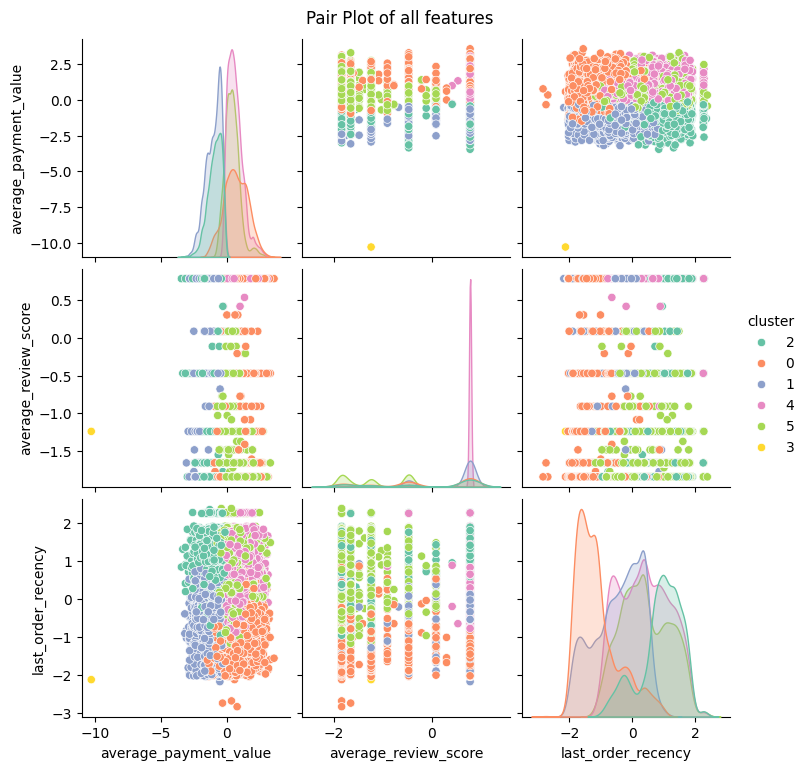

In [750]:
# Création des pairplots
sns.pairplot(X_reduced.sample(25000)[features_list + ['cluster']], hue='cluster', palette='Set2')
plt.suptitle("Pair Plot of all features", y=1.02)
plt.show()


J'évalue la répartition au sein des différents clusters:

In [751]:
cluster_sizes = X_reduced['cluster'].value_counts().sort_index()

fig = make_subplots(
    rows=1, cols=2, 
    specs=[[{'type': 'pie'}, {'type': 'bar'}]], 
    subplot_titles=("Cluster Size Distribution (Pie Chart)", "Cluster Size Distribution (Bar Chart)")
)

fig.add_trace(
    go.Pie(
        labels=cluster_sizes.index,
        values=cluster_sizes.values,
        hole=.3,
        textinfo='label+percent',
    ),
    row=1, col=1
)

fig.add_trace(
    go.Bar(
        x=cluster_sizes.index,
        y=cluster_sizes.values,
        marker_color=px.colors.qualitative.G10,
    ),
    row=1, col=2
)

fig.update_layout(
    title_text="Cluster Size Representation",
    height=600,
    width=1000,
    showlegend=False
)

fig.show()

Enfin, j'évalue leur interprétabilité avec une heatmap.

In [752]:
# Visualisation des caractéristiques de chaque cluster
px.imshow(X_reduced.groupby('cluster').mean())

Il semblerait que le clustering de Birch ait plus de mal à gérer les outliers, malgré les transformations effectuées; ce qui donne certains clusters incohérents et/ou quasi vides.

### 2.3 DBSCAN

Je teste DBSCAN sur de nombreuses possibilités d'hyperparamètres.

In [760]:
from sklearn.cluster import DBSCAN

best_score = -1
best_params = {}
best_labels = None
eps_values = [0.3, 0.5, 0.7, 1.0]
min_samples_values = [2, 5, 10]

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_sample_reduced)
        if len(set(labels)) > 1: 
            score = metrics.silhouette_score(X_sample_reduced, labels)
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}
                best_labels = labels

n_clusters = len(set(best_labels)) - (1 if -1 in best_labels else 0)

print(f'Best DBSCAN parameters: {best_params}')
print(f'Best DBSCAN silhouette score: {best_score}')
print(f'Number of clusters: {n_clusters}')


Best DBSCAN parameters: {'eps': 1.0, 'min_samples': 2}
Best DBSCAN silhouette score: 0.7867749869280329
Number of clusters: 1


In [763]:
X_sample_reduced['cluster'] = best_labels
X_sample_reduced['cluster'] = X_sample_reduced['cluster'].astype(str)
X_sample_reduced = X_sample_reduced.sort_values(by='cluster', key=lambda x: x.astype(int))

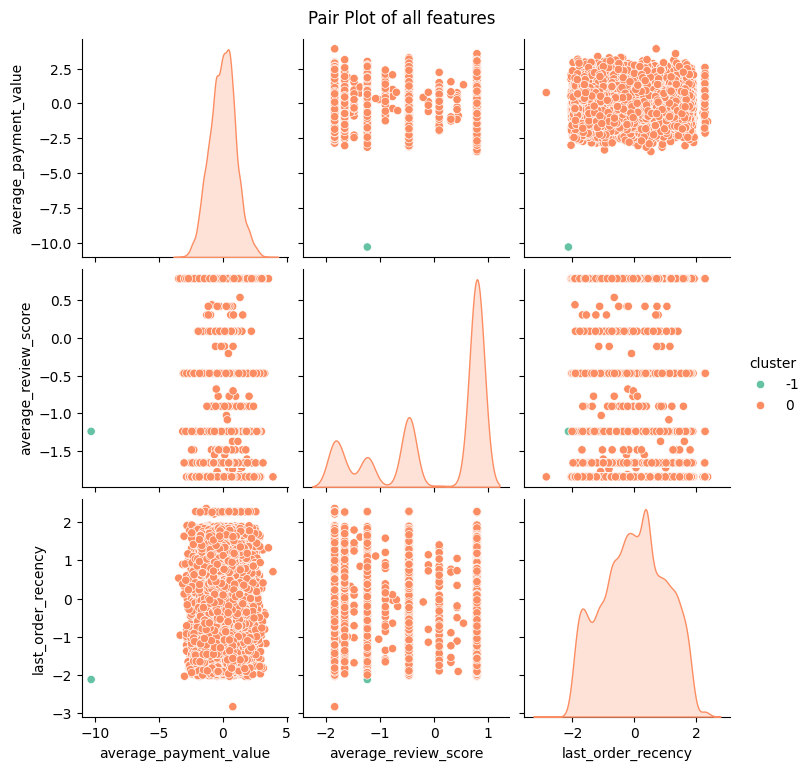

In [764]:
# Création des pairplots
sns.pairplot(X_sample_reduced[features_list + ['cluster']], hue='cluster', palette='Set2')
plt.suptitle("Pair Plot of all features", y=1.02)
plt.show()


In [765]:
cluster_sizes = X_sample_reduced['cluster'].value_counts().sort_index()

fig = make_subplots(
    rows=1, cols=2, 
    specs=[[{'type': 'pie'}, {'type': 'bar'}]], 
    subplot_titles=("Cluster Size Distribution (Pie Chart)", "Cluster Size Distribution (Bar Chart)")
)

fig.add_trace(
    go.Pie(
        labels=cluster_sizes.index,
        values=cluster_sizes.values,
        hole=.3,
        textinfo='label+percent',
    ),
    row=1, col=1
)

fig.add_trace(
    go.Bar(
        x=cluster_sizes.index,
        y=cluster_sizes.values,
        marker_color=px.colors.qualitative.G10,
    ),
    row=1, col=2
)

fig.update_layout(
    title_text="Cluster Size Representation",
    height=600,
    width=1000,
    showlegend=False
)

fig.show()

Il paraît clair que DBSCAN n'est pas un algorithme adapté pour les données d'Olist.

Après test de plusieurs types de modèles de clustering, KMeans semble être le plus adapté, et il sera donc l'algorithme retenu pour proposer la segmentation finale.